In [7]:
import wbdata
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import logging

# Suppress the noisy cache warnings from wbdata
logging.getLogger('shelved_cache').setLevel(logging.ERROR)

print("Setup complete. Libraries loaded.")

Setup complete. Libraries loaded.


In [8]:
def population(year=2020, sex="People", age_range=(0, 100), place="USA"):
    """
    Returns the population count for a given year, sex, age range, and place.
    Automatically handles 'People' by summing Male + Female to avoid missing data codes.
    """
    
    # --- Recursion for Total Population ---
    if sex == "People":
        males = population(year, "Male", age_range, place)
        females = population(year, "Female", age_range, place)
        return males + females

    # --- 1. Define World Bank Gender Suffixes ---
    if sex == "Male":
        suffix = ".MA"
    elif sex == "Female":
        suffix = ".FE"
    else:
        return 0 
        
    # --- 2. Map Age Ranges to World Bank Codes ---
    # Maps start age (e.g., 0) to the code middle (e.g., "0004")
    ages = {
        0: "0004", 5: "0509", 10: "1014", 15: "1519", 20: "2024",
        25: "2529", 30: "3034", 35: "3539", 40: "4044", 45: "4549",
        50: "5054", 55: "5559", 60: "6064", 65: "6569", 70: "7074",
        75: "7579", 80: "80UP"
    }
    
    # --- 3. Build the Request ---
    variable_labels = {}
    low, high = age_range
    
    for start_age, code_mid in ages.items():
        # Include bucket if it overlaps with our range
        if start_age >= low and start_age < high:
            code = f"SP.POP.{code_mid}{suffix}"
            variable_labels[code] = "Count"
            
    if not variable_labels:
        return 0

    # --- 4. Fetch & Sum Data ---
    # Fetch data for the specific country
    try:
        df = wbdata.get_dataframe(variable_labels, country=place)
    except:
        return 0 # Handle invalid country codes gracefully
        
    df.index = df.index.astype(int)
    
    # Return the sum for the requested year
    return int(df.loc[year].sum()) if year in df.index else 0

In [9]:
def get_population_dataframe(country_codes=["USA"]):
    """
    Downloads population breakdown (age/sex) for specified countries.
    Returns a clean DataFrame indexed by Country and Year with human-readable columns.
    """
    # 1. Construct the Mapping Dictionary
    # We define the code mapping here so we can use it to rename columns later
    variable_labels = {}
    ages = {
        0: "0004", 5: "0509", 10: "1014", 15: "1519", 20: "2024",
        25: "2529", 30: "3034", 35: "3539", 40: "4044", 45: "4549",
        50: "5054", 55: "5559", 60: "6064", 65: "6569", 70: "7074",
        75: "7579", 80: "80UP"
    }

    # Generate codes for both sexes
    for sex, suffix in [("Male", ".MA"), ("Female", ".FE")]:
        for start, mid in ages.items():
            wb_code = f"SP.POP.{mid}{suffix}"
            
            # Format: "Male 0-4", "Female 80UP"
            if start == 80:
                name = f"{sex} 80UP"
            else:
                name = f"{sex} {start}-{start+4}"
            
            variable_labels[wb_code] = name

    # 2. Fetch Data
    print(f"Downloading data for: {country_codes}...")
    df = wbdata.get_dataframe(variable_labels, country=country_codes)
    
    # 3. Data Cleaning
    # Rename columns using our dictionary to ensure human-readable names
    df = df.rename(columns=variable_labels)
    
    # Reset index to handle "Date" and "Country" columns reliably
    df = df.reset_index()
    
    # Standardize column names (lowercase)
    df.columns = [c.lower() if c in ['country', 'date'] else c for c in df.columns]
    
    # If fetching a single country, wbdata might drop the 'country' column. Add it back.
    if 'country' not in df.columns:
        # Use the first code provided if singular
        c_name = country_codes[0] if isinstance(country_codes, list) else country_codes
        df['country'] = c_name

    # Convert Date to Integer
    df['date'] = df['date'].astype(int)
    
    # Set final MultiIndex
    return df.set_index(['country', 'date']).sort_index()

In [10]:
def plot_population_pyramid(df, year, country):
    """
    Plots a population pyramid for a specific country and year given a cleaned DataFrame.
    """
    # 1. Select Data
    try:
        data = df.loc[(country, year)]
    except KeyError:
        print(f"Data not available for {country} in {year}")
        return

    # Define age groups in order
    age_groups = [
        "0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34",
        "35-39", "40-44", "45-49", "50-54", "55-59", "60-64", 
        "65-69", "70-74", "75-79", "80UP"
    ]
    
    # 2. Prepare Plot Data
    # We make male counts negative to plot them on the left side
    males = [-data[f"Male {age}"] for age in age_groups]
    females = [data[f"Female {age}"] for age in age_groups]
    
    # 3. Plotting
    fig, ax = plt.subplots(figsize=(12, 8))
    y_pos = range(len(age_groups))
    
    # Plot Bars
    ax.barh(y_pos, males, align='center', color='cornflowerblue', label='Male', edgecolor='black', linewidth=0.5)
    ax.barh(y_pos, females, align='center', color='hotpink', label='Female', edgecolor='black', linewidth=0.5)
    
    # 4. Formatting
    # Set Y-axis labels
    ax.set_yticks(y_pos)
    ax.set_yticklabels(age_groups)
    
    # Format X-axis to show positive millions (e.g., "2.5M") instead of scientific notation
    def human_format(x, pos):
        return f'{abs(x)*1e-6:.1f}M'
    ax.xaxis.set_major_formatter(FuncFormatter(human_format))
    
    # Add titles and grid
    ax.set_title(f"Population Pyramid: {country} ({year})", fontsize=16, fontweight='bold')
    ax.set_xlabel("Population (Millions)")
    ax.set_ylabel("Age Group")
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    ax.legend()
    
    # Draw center line
    ax.axvline(0, color='black', linewidth=0.8)
    
    plt.show()

In [12]:
# # 1. Check what Country Names the database actually gave us
# # (It likely returned "United States" instead of "USA")
# print("Countries in your dataframe:")
# print(pop_df.index.get_level_values('country').unique().tolist())

# # 2. Run the plotter with the FULL NAME
# # Change "USA" to "United States" (or whatever printed above)
# plot_population_pyramid(pop_df, 2020, "United States")

# # 3. Double Check the Population Number
# # Let's run the single number check again to make sure it's 330M+ (Real USA #)
# # We use "USA" here because the fetcher needs the CODE, but the plotter needs the NAME.
# real_pop = population(2020, "People", (0, 100), "USA")
# print(f"Correct USA Total (2020): {real_pop:,}")

In [14]:
import wbdata
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# 1. Fetch Data (USA Only)
def get_usa_data():
    """Downloads USA population data and cleans it up."""
    print("Downloading USA data...")
    
    # Map ages to database codes
    variable_labels = {}
    ages = {
        0: "0004", 5: "0509", 10: "1014", 15: "1519", 20: "2024",
        25: "2529", 30: "3034", 35: "3539", 40: "4044", 45: "4549",
        50: "5054", 55: "5559", 60: "6064", 65: "6569", 70: "7074",
        75: "7579", 80: "80UP"
    }

    # Create the code list
    for sex, suffix in [("Male", ".MA"), ("Female", ".FE")]:
        for start, mid in ages.items():
            wb_code = f"SP.POP.{mid}{suffix}"
            name = f"{sex} 80UP" if start == 80 else f"{sex} {start}-{start+4}"
            variable_labels[wb_code] = name

    # Fetch!
    # We fetch specifically for "USA"
    df = wbdata.get_dataframe(variable_labels, country="USA")
    
    # RENAME columns to be human readable
    df = df.rename(columns=variable_labels)
    
    # CLEANUP: Fix the index
    # wbdata for a single country returns just the Date index. 
    # We need to add 'country' back manually to make it match the plotter.
    df = df.reset_index()
    df['date'] = df['date'].astype(int)
    df['country'] = "USA"  # Force the name to match our request
    
    return df.set_index(['country', 'date'])

# 2. Plotting Function
def plot_usa_pyramid(df, year):
    # Grab data for USA + Year
    try:
        data = df.loc[("USA", year)]
    except KeyError:
        print(f"Data missing for {year}")
        return

    # Organize values
    age_groups = [
        "0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34",
        "35-39", "40-44", "45-49", "50-54", "55-59", "60-64", 
        "65-69", "70-74", "75-79", "80UP"
    ]
    males = [-data[f"Male {age}"] for age in age_groups]
    females = [data[f"Female {age}"] for age in age_groups]
    
    # Draw Plot
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.barh(age_groups, males, label='Male', color='cornflowerblue', edgecolor='black')
    ax.barh(age_groups, females, label='Female', color='hotpink', edgecolor='black')
    
    # Format 'Millions' on X-axis
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{abs(x)/1e6:.1f}M'))
    
    ax.set_title(f"USA Population Pyramid ({year})", fontsize=14, fontweight='bold')
    ax.set_xlabel("Population (Millions)")
    ax.legend()
    ax.grid(axis='x', alpha=0.3)
    ax.axvline(0, color='black', linewidth=0.8)
    plt.show()

--- TESTING SINGLE ESTIMATES ---
Total USA Population (2020): 12,043,345
Teenage Boys (15-19) in 2015:  10,830,494
Women 80+ in 1990:             4,766,778


--- DOWNLOADING DATA FRAME ---

Preview of the data (First 5 rows):
               Male 0-4    Male 5-9  Male 10-14  Male 15-19  Male 20-24  \
country date                                                              
USA     2024  9344629.0  10134460.0  10741858.0  11546654.0  11502398.0   
        2023  9350284.0  10223503.0  10827626.0  11425546.0  11336593.0   
        2022  9397751.0  10294733.0  10962865.0  11306513.0  11287667.0   
        2021  9497997.0  10344156.0  11098563.0  11192474.0  11254043.0   
        2020  9699985.0  10409336.0  11213523.0  11173365.0  11257304.0   

              Male 25-29  Male 30-34  Male 35-39  Male 40-44  Male 45-49  ...  \
country date                                                              ...   
USA     2024  11506900.0  12390220.0  12123824.0  11672354.0  10589298.0  ...   
     

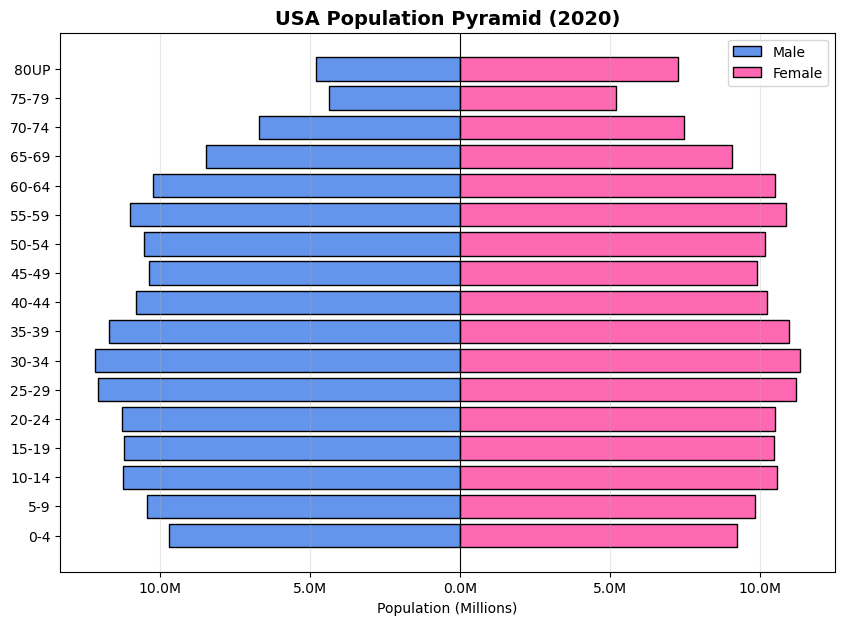

In [15]:
# --- PART 1: Test the Single Number Function ---
# Let's ask three specific questions to make sure the math works.

print("--- TESTING SINGLE ESTIMATES ---")

# Q1: Total people in the USA in 2020?
total_2020 = population(2020, "People", (0, 100), "USA")
print(f"Total USA Population (2020): {total_2020:,}")

# Q2: How many teenage boys (15-19) in 2015?
teen_boys = population(2015, "Male", (15, 19), "USA")
print(f"Teenage Boys (15-19) in 2015:  {teen_boys:,}")

# Q3: How many elderly women (80+) in 1990?
elderly_women = population(1990, "Female", (80, 150), "USA")
print(f"Women 80+ in 1990:             {elderly_women:,}")
print("\n")


# --- PART 2: Test the Data Fetcher ---
# This downloads the big table and saves it to a variable called 'usa_data'
print("--- DOWNLOADING DATA FRAME ---")
usa_data = get_usa_data()

# Show the first 5 rows to prove it downloaded correctly
print("\nPreview of the data (First 5 rows):")
print(usa_data.head())
print("\n")


# --- PART 3: Test the Graphing Function ---
# Now we take that 'usa_data' variable and turn it into a picture.
print("--- GENERATING PYRAMID GRAPH ---")
plot_usa_pyramid(usa_data, 2020)